# Introduction to FICO Xpress
Xpress is one of the state-of-the-art mathematical programming solvers out there. In essence, it enables us to formulate and solve mathematical programming problems  linear or convex quadratic objective function and constraints. While the solver itself is written in C, there are interfaces to C++, Java, Python and Matlab. Here, we are going to look at the Python interface.

# How to model a problem with Xpress
In this part, we will look at five different elements, which I think are the most important parts when building your model:
1. Variables
2. Constraints, including indicator constraints
3. Callbacks
4. More complex modeling elements (piecewise linear functions, multi-objective etc.)
5. How Xpress let's you know something is wrong

> Note: Xpress has two parts you can work with: the `xpress` object, which is a static object that allows you to access things such as custom `Sum` operators, variable and constraint definition etc. Then, you have your actual model object, called `problem` in the documentation, which represents the specific model instance you are working with. Note that throughout this notebook I will abbreviate `xpress` as `xp` and my model object will be called `mdl`.

## Variables
### Creating variables
All variables are created using the `xp.var()` method, the type of variable created is defined as a parameter of this method called `vartype`. The variable types at your disposal are:
- `xp.continuous` for continuous variables
- `xp.binary` for binary variables (lower and upper bound are further restricted to 0 and 1)
- `xp.integer` for integer variables
- `xp.semicontinuous` for semi-continuous variables, i.e. $x \in \{0\} \cup [l,u]$ with $0\leq l \leq u$ (see [here](http://yetanothermathprogrammingconsultant.blogspot.com/2016/08/semi-continuous-variables.html) for a nice description).
- `xp.semiinteger` for semi-integer variables
- `xp.partiallyinteger` for partially integer variables, i.e. $x \in \{l,...,t\} \cup [t,u]$ with $t \leq t \leq u$. This means, from $l$ to $t$ the variable is integer and from $t$ to $u$ the variable is continuous.

The rest about variable creation is pretty standard. You have `name`, `lb`, `ub` and `threshold` as parameters in `xp.var` (`threshold` only when needed). **Also, note that the default value for `lb` is 0.**

So let's look at some examples:

In [1]:
import xpress as xp

# Creating a single variable
x = xp.var(vartype = xp.continuous, lb = -5, ub = 5, name = 'x')

# Creating a dictionary of variables
y = {k : xp.var(vartype = xp.binary, lb = 0, ub = 1, name = f'y_{k}') for k in range(10)}

### Adding variables to a model
Note that we have simply created some variables, without associating them to an actual model. So let's do that:

In [2]:
mdl = xp.problem("Variable testing")
mdl.addVariable(x,y)
mdl.solve()

### Getting the solution values out
So to add variables, you need to use the command `addVariable`. Now let's see how we can inspect the solution to our problem:

In [3]:
mdl.getSolution(x)

-5.0

However, if you want to get the solution of multiple values, it gets a bit trickier, because `mdl.getSolution(y)` will simply throw you an error:

In [5]:
mdl.getSolution()

[-5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

So you need to loop through all values of individually to extract the information:

In [19]:
[mdl.getSolution(y[k]) for k in range(10)]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Personally, I find this a bit clunky, because I need to iterate over the model object (which contains everything) a lot of times. However, there is sadly no other way I am aware of.

## Constraints
### Defining constraints
In principle, adding constraints is super-simple in Xpress: simply type `addConstraint`, write down your constraint and you are good to go. For example, in the Python documentation for Xpress (e.g. page 5), you will see the following: `mdl.addConstraint (xp.Sum ([y[i] for i in range (10)]) <= 1)`. 

However, while this works, this directly goes against one of my modelling rules, which is to **always** name your constraints. And this, sadly, is not directly possible from using `addConstraint`. To name your constraint, you have to make a constraint object using `xp.constraint`, and then run `mdl.addConstraint` in a second step:

In [3]:
cstr1 = xp.constraint(x <= 5, name = 'x bounding')
mdl.addConstraint(cstr1)

### Inspecting constraints
A common thing, especially when debugging your model, is to what to inspect your constraint to make sure you really have included all terms in that mass balance, or you have not forgotten a factory in your assignment problem. So how can you do this in Xpress? Well, not that easily unfortunately: if you simply type e.g. `cstr1` and hit enter, you will simply get a print out of the name itself.

In [4]:
cstr1

x bounding

So what properties are exposed of this constraint? You have `body`, `lb`, `ub`, `name` and `copy` (which is a method that simply copies the constraint). `lb` and `ub` are floats, and `body` is an `xp.expression`, that contains the "meat" of the constraint. However, while you get a printout of the body if you type `cstr1.body` and hit enter, you cannot actually do anything with it.

In [5]:
cstr1.body

  x

I cannot know for sure, but I suspect this is because the constraint object, much like the variable object, is created statically by `xp.constraint`, rather than directly as part of the model. This is unlike other solvers such as CPLEX, where the constraint is directly added to the model. The result? You have to look at the string output of the body, or get a `.lp` file printout and look at that.

### Indicator constraints
Indicator constraints (sometimes also called "if-then" or "conditional" constraints) denote the following type of constraint: *if $\sum \limits_j a_{ij}x_j \leq b_i$ holds, then $\sum \limits_j a_{kj}x_j \leq b_k$ has to hold*. Mathematically, it is often represented using an "imply" arrow ($\Rightarrow$):
\begin{equation}
\sum \limits_j a_{ij}x_j \leq b_i \Rightarrow \sum \limits_j a_{kj}x_j \leq b_k
\end{equation}
There are ways to reformulate this constraints (see e.g. [here](https://download.aimms.com/aimms/download/manuals/AIMMS3OM_IntegerProgrammingTricks.pdf)) using binary variables, although there is an $\epsilon$ to be tweaked.

So how does Xpress handle this? There are indicator constraints in `Xpress`, but with a couple of caveats:
1. You have to use `addIndicator`, and as such (a) cannot add a name to the indicator constraint and (b) cannot add more than one at the same time.
2. You can only use $y=0$ and $y=1$ on the left side of the indicator. This means, if you wanted to write a general indicator constriant like the one above, you would need to manually write an indicator constraint that sets an auxiliary variable to $0$ or $1$, and then use that in the `addIndicator` method.

Let's see an example of this:

In [50]:
# A valid indicator constraint in Xpress
mdl.addIndicator(x == 1, xp.Sum(y[k] for k in range(10)) >= 5)

In [49]:
# Anything else but ==1 or ==0 will give an error though:
mdl.addIndicator(x >= 1, xp.Sum(y[k] for k in range(10)) >= 5)

RuntimeError: Invalid condition for indicator constraints: must be <variable_name> == 0 or <variable_name> == 1

In [48]:
# Lastly, let's try a sum of variables:
mdl.addIndicator(xp.Sum(y[k] for k in range(10)) == 1, x >= 5)

RuntimeError: Invalid condition for indicator constraints: there must be exactly one variable

## Callbacks
A callback is way to interact with a solver during its execution. For Xpress, this section is going to be pretty short, as I have found callbacks to be pretty easy to use: simply write a separate function that contains what you want to be called during the execution at a given point, and add it with the corresponding `mdl.addcb[...]` command. But at what points in the execution can I inject a callback from Xpress? Pretty much anywhere, so just check in the [manual](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/GUID-616C323F-05D8-3460-B0D7-80F77DA7D046.html).

One note there is to be made on callbacks: the function you add always has to follow the structure that is laid out in the manual. So if you want to make your `optsol` callback a `globallog` callback, you may need to change the input/output structure of the callback to make it work.

Let's look at a simple example:

In [60]:
mdl = xp.problem("Testing callbacks")
n = 10000
range_n = range(n)
x = {i : xp.var(vartype = xp.binary, name = f'x_{i}') for i in range_n}
mdl.addVariable(x)
mdl.setObjective(xp.Sum(-i*x[i]*x[i] for i in range_n))
cstr1 = xp.constraint(xp.Sum(i*x[i] for i in range_n) <= 5000, name='First constraint')
cstr2 = xp.constraint(xp.Sum(x[i] for i in range_n) >= 10, name='Second constraint')
mdl.addConstraint(cstr1,cstr2)
mdl.solve()

Now let's add a callback that fires every time we write a new line in the log file:

In [63]:
def globalLog(prob, object):
    nodedepth = prob.attributes.nodedepth
    node = prob.attributes.currentnode
    print (f'Node {node} with depth {nodedepth} has been processed')
    return 0

mdl.addcbgloballog (globalLog, None, 0)
mdl.solve()

Node 1 with depth 1 has been processed
Node 1 with depth 1 has been processed
Node 1 with depth 3 has been processed
Node 1 with depth 3 has been processed
Node 1 with depth 3 has been processed
Node 1 with depth 3 has been processed
Node 1 with depth 4 has been processed
Node 1 with depth 4 has been processed
Node 1 with depth 4 has been processed
Node 1 with depth 4 has been processed
Node 1 with depth 5 has been processed
Node 1 with depth 5 has been processed
Node 1 with depth 6 has been processed
Node 1 with depth 6 has been processed
Node 1 with depth 7 has been processed
Node 1 with depth 7 has been processed
Node 1 with depth 12 has been processed
Node 1 with depth 12 has been processed
Node 1 with depth 12 has been processed
Node 1 with depth 12 has been processed


## More complex modeling elements
If you come from e.g. CPLEX, you may be used to having elements like piecewise linear functions available for you to use, or even multi-objective optimization possibilities in Gurobi. However, to make it short, there are currently (Xpress 8.5.11) no such things available in Xpress, at least from Python. You have your variables, your constraints and your callbacks, and that's pretty much it. Anything else you need to make by yourself.

Also, note that as of Xpress 8.5.11 the variable objects are not picklable (i.e. not serializable with the `pickle` module), so that may have a hit on performance for model building for very large models.

## Model error reporting in Xpress
If you are like me, you make a ton of mistakes when coding up models: copy-pasting some code without changing variable names, adding the same constraint twice etc. What I really appreciate about a library is when it tells me when (and especially how) I messed up. So how does Xpress do this? Let's look at a couple of example and see:

In [69]:
mdl = xp.problem("Testing error messages")
# Here I forget to write "vartype"
x = xp.var(xp.binary)

RuntimeError: Invalid variable name (must be a string)

In [68]:
# Now I add a variable with the same name twice
x = xp.var(name='x')
y = xp.var(name='x')
mdl.addVariable(x,y)

SystemError: <built-in method addVariable of xpress.problem object at 0x00000030C43F0D30> returned NULL without setting an error

This error message: `<built-in method [...] of xpress.problem object at [...]> returned NULL without setting an error` is very common in Xpress, and does not say anything. However, if we look over to the Jupyer notebook console, we read `1030 Error: Duplicate column names are not allowed - column 0 would have same name as column 1`.

This is a very common theme, especially when you work with Jupyer notebooks. The exceptions that are thrown on screen are non-sensical, but the errors reported in the console are on spot. Lastly, let's introduce an error in the callback example from above:

In [70]:
mdl = xp.problem("Testing callback error")
n = 10000
range_n = range(n)
x = {i : xp.var(vartype = xp.binary, name = f'x_{i}') for i in range_n}
mdl.addVariable(x)
mdl.setObjective(xp.Sum(-i*x[i]*x[i] for i in range_n))
cstr1 = xp.constraint(xp.Sum(i*x[i] for i in range_n) <= 5000, name='First constraint')
cstr2 = xp.constraint(xp.Sum(x[i] for i in range_n) >= 10, name='Second constraint')
mdl.addConstraint(cstr1,cstr2)

# I simply removed the 'object' in the function name
def globalLog(prob):
    nodedepth = prob.attributes.nodedepth
    node = prob.attributes.currentnode
    print (f'Node {node} with depth {nodedepth} has been processed')
    return 0

mdl.addcbgloballog (globalLog, None, 0)
mdl.solve()

TypeError: globalLog() takes 1 positional argument but 2 were given

# How fast can I build a model
To give you a feel on how long it takes to build something in Xpress, I am simply going to evaluate: (a) how much time does adding $10^7$ variables take, (b) how much time does it take to add $10^5$ sparse (i.e. 10 non-zero elements) or $10^3 dense constraints ($10^3$ non-zero elements), and (c) what is the performance hit of a simple callback?

## (a) Adding variables

In [12]:
n = 10000000

def variable_addition(n):
    mdl = xp.problem("Timing variables")
    x = {k : xp.var(vartype = xp.continuous, lb = -10, ub = 10, name = f'x_{k}') for k in range(n)}
    mdl.addVariable(x)
    
# Time the whole thing
%timeit variable_addition(n)

# To verify, let's time the creation of the dictionary:
%timeit x = {k : xp.var(vartype = xp.continuous, lb = -10, ub = 10, name = f'x_{k}') for k in range(n)}

2.82 s ± 247 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.47 s ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


By the way, the reason we had to package the `variable creation` away was because otherwise Xpress would complain that we add a variable with the same name again. So, about 30% of the time is spent on creating the dictionary, and about 70% is spent on adding the variables to the model object. So just out of curiosity, how does this scale with $n$? Let's see:

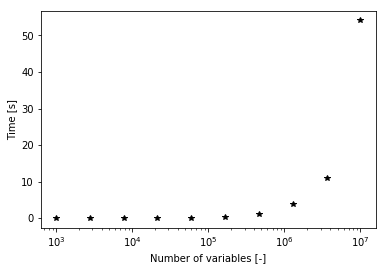

In [17]:
import time
import matplotlib.pyplot as plt
import numpy as np

# The array of values of n to be considered
range_n = np.logspace(3.0, 7.0, num=10)

for n in range_n:
    start_time = time.time()
    variable_addition(int(n))
    plt.semilogx(n, time.time() - start_time,'k*')
    
plt.xlabel('Number of variables [-]')
plt.ylabel('Time [s]')
plt.show();

So everything up to $5\cdot 10^6$ variables is ok, but then it drastically increases in time.

## (b) Adding constraints
First, let's do the sparse constraints. We add $10^5$ constraints with $10$ entries (so $10^6$ non-zero values in total). Let's see how Xpress handles that. First, we define some data, and then we `%timeit`:

In [34]:
m = 100000
cstr_n = 10
n = 100000

def constraint_addition(ctr_matrix, m, n, cstr_n):
    mdl = xp.problem("Timing variables")
    x = {k : xp.var(vartype = xp.continuous, lb = -10, ub = 10, name = f'x_{k}') for k in range(n)}
    mdl.addVariable(x)
    
    mdl.addConstraint([xp.Sum(ctr_matrix[i,j]*x[j] for j in range(cstr_n)) <= 5 for i in range(m)])

# Generate constraint matrix
ctr_matrix = 10*(np.random.rand(m,cstr_n) - 0.5)

In [35]:
# Run %timeit
%timeit constraint_addition(ctr_matrix, m, n, cstr_n)

22.7 s ± 8.63 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ok, now let's look at adding $10$ constraints with $10^5$ entries (so again $10^6$ non-zero values). This we can achieve by simply transposing the `ctr_matrix` we got above. Does this make a difference?

In [36]:
# Run %timeit
%timeit constraint_addition(ctr_matrix.T, cstr_n, n, n)

11.2 s ± 1.01 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


So this is interesting: even though the number of non-zero entries is the same, the sparse version takes about twice as long. But it also means that adding 10 (!) constraints takes over 10 seconds, which is a lot. Is this a general trend? Let's find out:

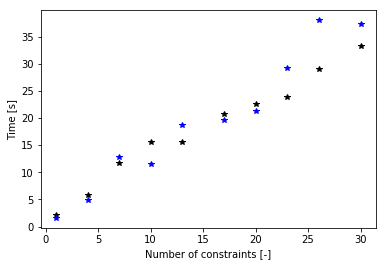

In [38]:
import time
import matplotlib.pyplot as plt
import numpy as np

# The array of values of n to be considered
range_m = np.linspace(1,30,10)
n = int(1e5)

for m_flt in range_m:
    # Convert to integer and create matrix
    m = int(m_flt)
    ctr_matrix = 10*(np.random.rand(m,n) - 0.5)
    
    # Running the test
    start_time = time.time()
    constraint_addition(ctr_matrix.T, n, n, m)
    end_time_sparse = time.time() - start_time
    
    start_time = time.time()
    constraint_addition(ctr_matrix, m, n, n)
    end_time_dense = time.time() - start_time
    
    # Plotting
    plt.plot(m, end_time_sparse,'k*')
    plt.plot(m, end_time_dense,'b*')
    
plt.xlabel('Number of rows/columns [-]')
plt.ylabel('Time [s]')
plt.show();

It seems to be this way: while there is some discrepancy, the overall trend really seems to be that it scales with the number of non-zero elements.

## (c) Callbacks overhead
Adding callbacks generally has an impact on the performance, because the solver needs to do something else other than solve. But how large is the hit? We'll try to figure out by using a scaled version of our example from before, with an increased log density:

> Note: I changed the callback from a printout to a simple calculation, because printing itself also incurs an overhead that we make the results non-sensical.

In [40]:
def globalLog(prob, object):
    nodedepth = prob.attributes.nodedepth
    node = prob.attributes.currentnode
    calc = nodedepth*node
    return 0

def callback_test(use_callback):
    mdl = xp.problem("Testing callbacks")
    n = 10000
    range_n = range(n)
    x = {i : xp.var(vartype = xp.binary, name = f'x_{i}') for i in range_n}
    mdl.addVariable(x)
    mdl.setObjective(xp.Sum(-i*x[i]*x[i] for i in range_n))
    cstr1 = xp.constraint(xp.Sum(i*x[i] for i in range_n) <= 5000, name='First constraint')
    cstr2 = xp.constraint(xp.Sum(x[i] for i in range_n) >= 10, name='Second constraint')
    mdl.addConstraint(cstr1,cstr2)
    
    mdl.controls.miplog = 3
    if use_callback:
        mdl.addcbgloballog (globalLog, None, 0)
    mdl.solve()
    
# First, no callback used
%timeit callback_test(False)

# Now use the callback
%timeit callback_test(True)

1.46 s ± 210 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.29 s ± 27.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Even though this callback is called quite a bit (around 100 times or so I think), it has a "positive" effect (i.e. no effect) on the performance. While this will of course not be true if you do more involved things in the callback, this is an indication that the callback itself does not really "cost" much.

# Conclusion
How good is the Xpress Python API? Well, based on what I have just shown you, it depends: in some things it works very well and nicely, however there is still a lot of room for improvement, especially in the indicator constraints and modelling features department. Also a bit worringly, the addition of dense constraints seems to be very expensive, but I am not sure how other solvers would fare in this regard. But there is ways around this using `addrows`, where you manually add the row to the problem without going through the API, and thus removing this overhead.

But if you have any comments/questions regarding my test, just come and find me on [Twitter](https://twitter.com/ROberdieck) or [LinkedIn](https://www.linkedin.com/in/oberdieck/).